In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
path_prefix = './cs5228-2310-final-project/'
df_train = pd.read_csv(path_prefix + 'train.csv')
df_test = pd.read_csv(path_prefix + 'test.csv')

In [4]:
df_train.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


## Data Preprocessing

In [8]:
#data clean
df_train.isnull().sum()

rent_approval_date     0
town                   0
block                  0
street_name            0
flat_type              0
flat_model             0
floor_area_sqm         0
furnished              0
lease_commence_date    0
latitude               0
longitude              0
elevation              0
subzone                0
planning_area          0
region                 0
monthly_rent           0
dtype: int64

In [9]:
df_train.dtypes

rent_approval_date      object
town                    object
block                   object
street_name             object
flat_type               object
flat_model              object
floor_area_sqm         float64
furnished               object
lease_commence_date      int64
latitude               float64
longitude              float64
elevation              float64
subzone                 object
planning_area           object
region                  object
monthly_rent             int64
dtype: object

In [10]:
df_train.describe()
df_train['rent_approval_date'] = pd.to_datetime(df_train['rent_approval_date'])
df_train['rent_approval_year'] = df_train['rent_approval_date'].dt.year
df_train['rent_approval_month'] = df_train['rent_approval_date'].dt.month/12 + df_train['rent_approval_date'].dt.year

<Axes: >

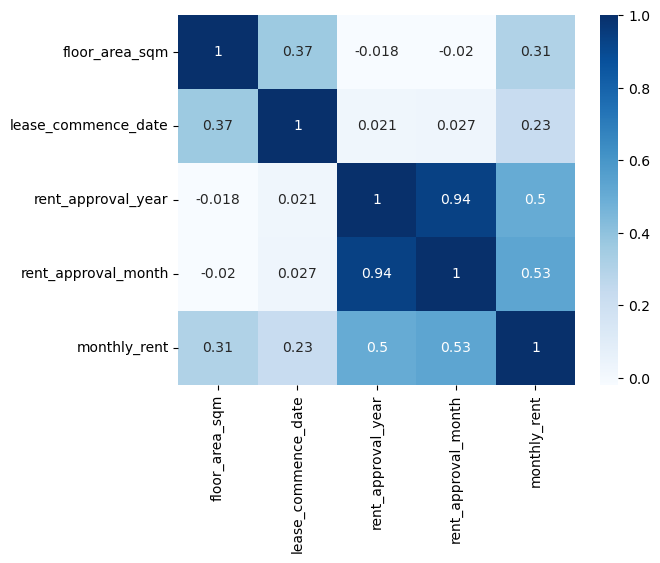

In [11]:
#draw corr heatmap
corr = df_train[['floor_area_sqm', 'lease_commence_date', 'rent_approval_year', 'rent_approval_month', 'monthly_rent']].corr()
sns.heatmap(corr, annot=True, cmap='Blues')

c:\ProgramData\anaconda3\envs\CS5228\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


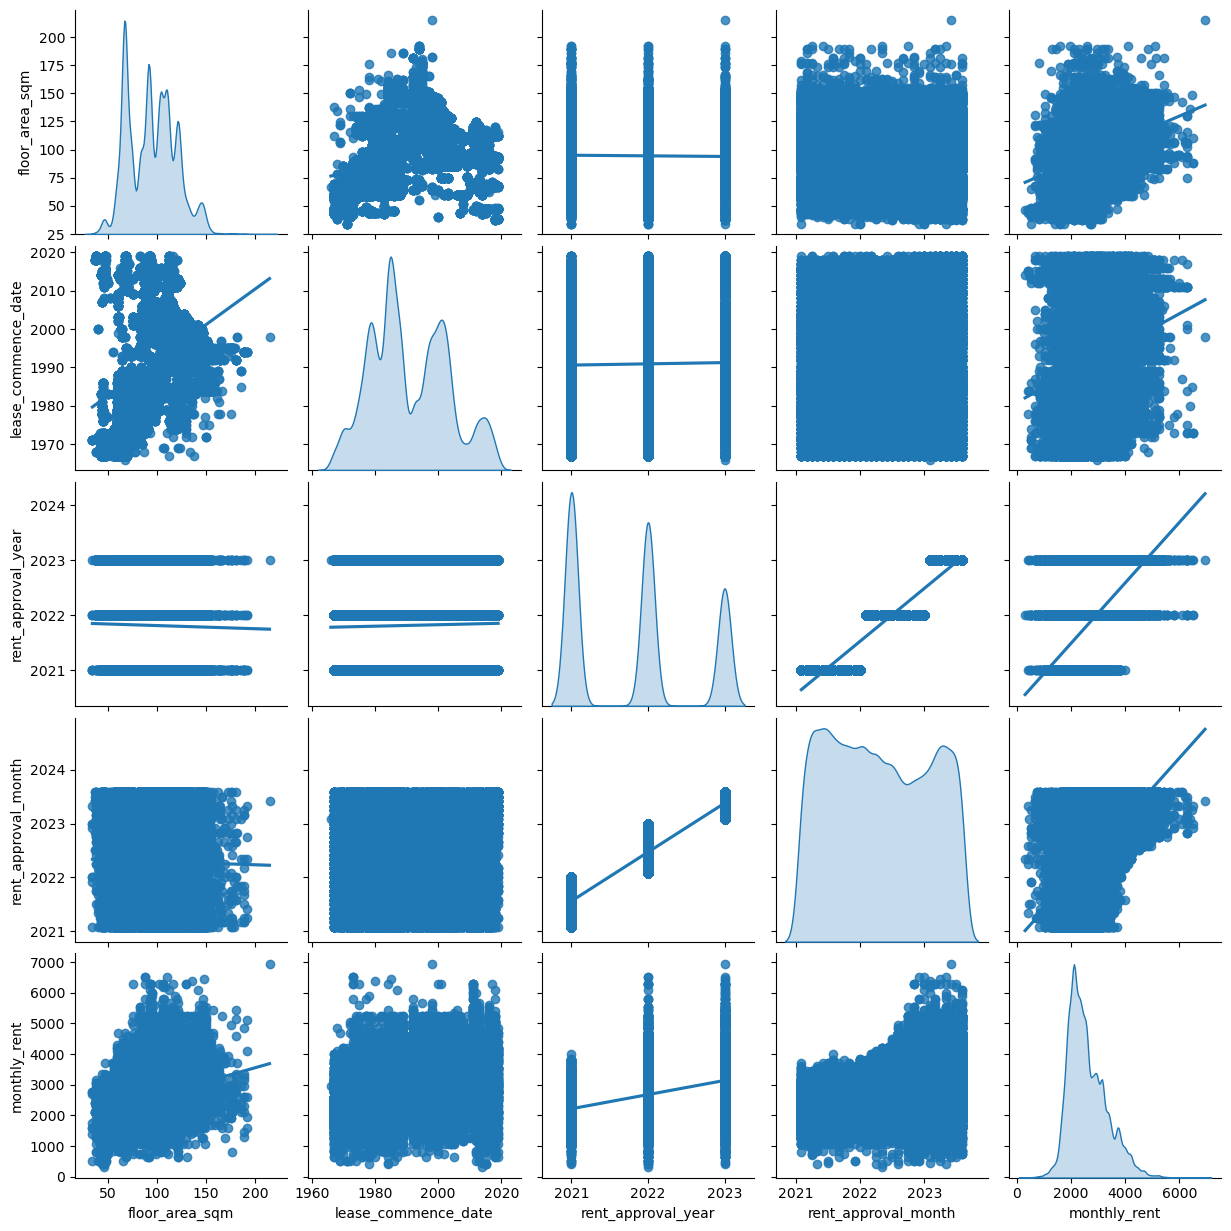

In [12]:
#draw corr distribution plot
sns.pairplot(df_train[['floor_area_sqm', 'lease_commence_date', 'rent_approval_year', 'rent_approval_month', 'monthly_rent']], diag_kind='kde', kind='reg')


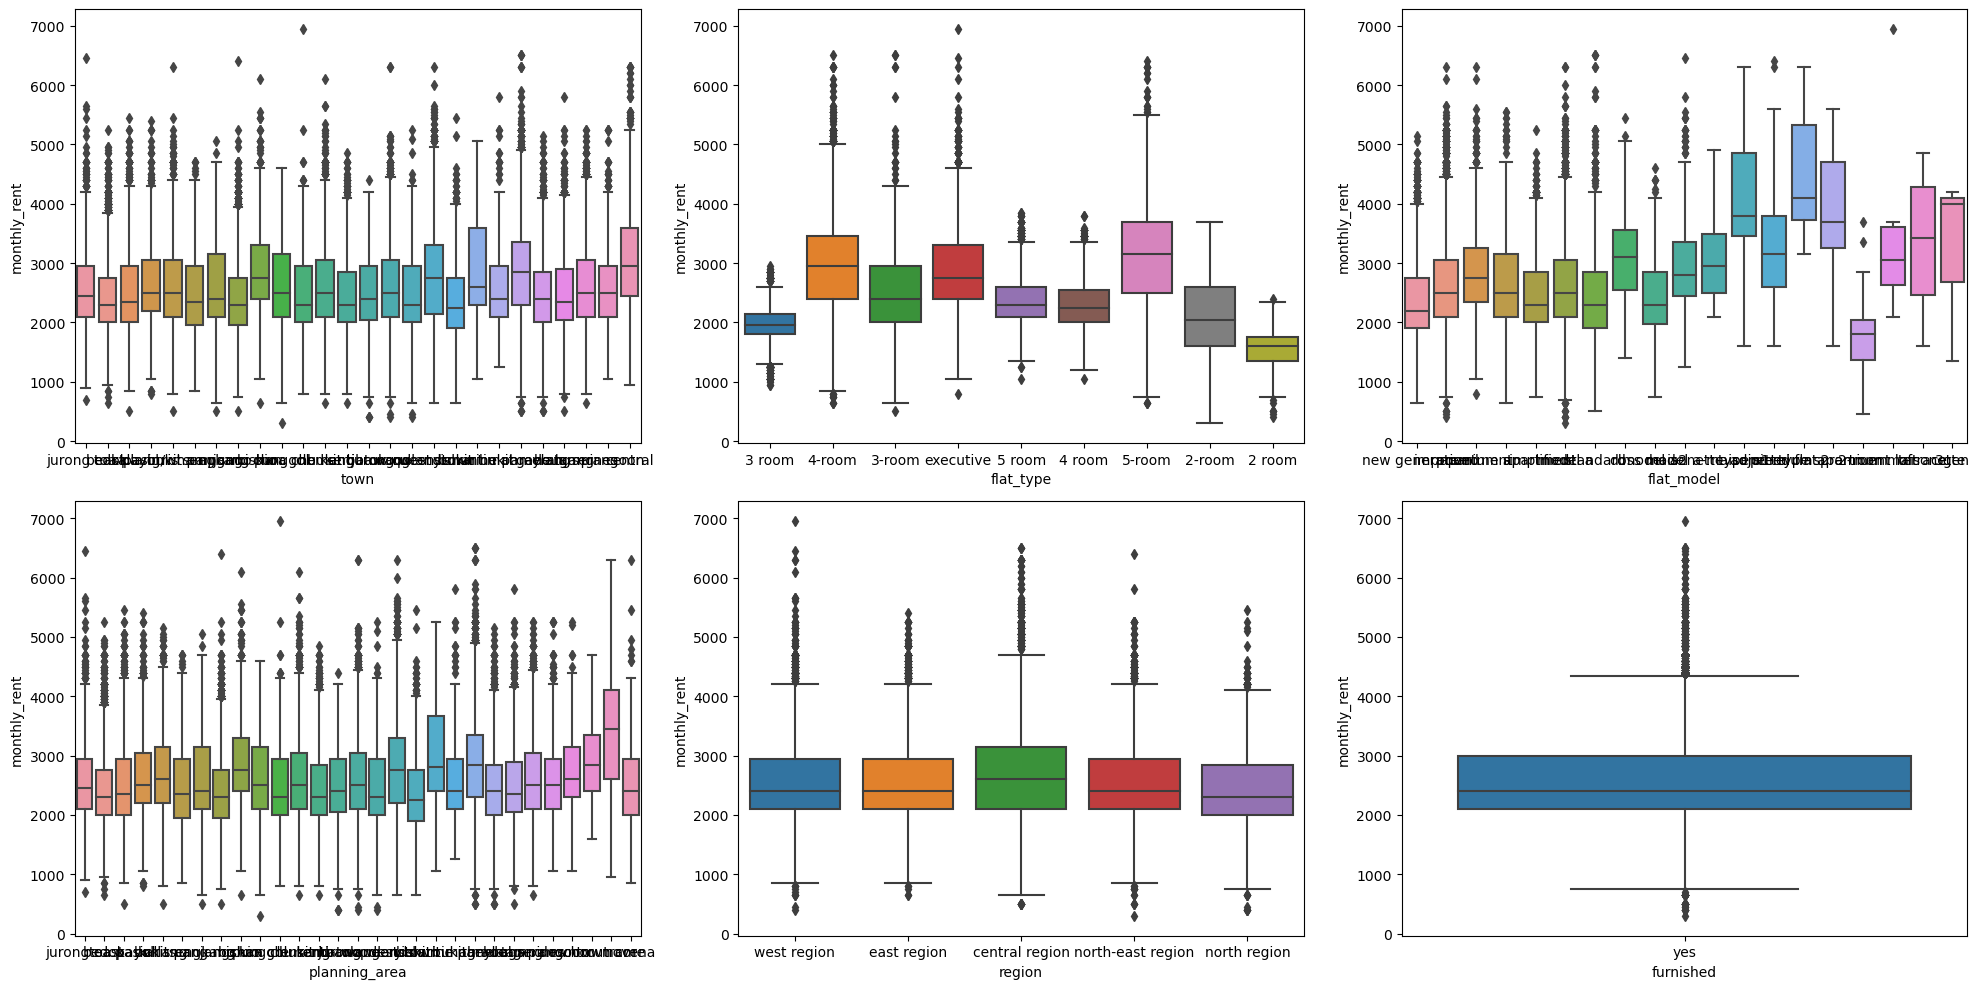

In [11]:
#draw distribution for categorical variables and monthly rent
#town	street_name	flat_type	flat_model	subzone	planning_area	region
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
sns.boxplot(x='town', y='monthly_rent', data=df_train, ax=ax[0, 0])
sns.boxplot(x='flat_type', y='monthly_rent', data=df_train, ax=ax[0, 1])
sns.boxplot(x='flat_model', y='monthly_rent', data=df_train, ax=ax[0, 2])
sns.boxplot(x='planning_area', y='monthly_rent', data=df_train, ax=ax[1, 0])
sns.boxplot(x='region', y='monthly_rent', data=df_train, ax=ax[1, 1])
sns.boxplot(x='furnished', y='monthly_rent', data=df_train, ax=ax[1, 2])
plt.tight_layout()



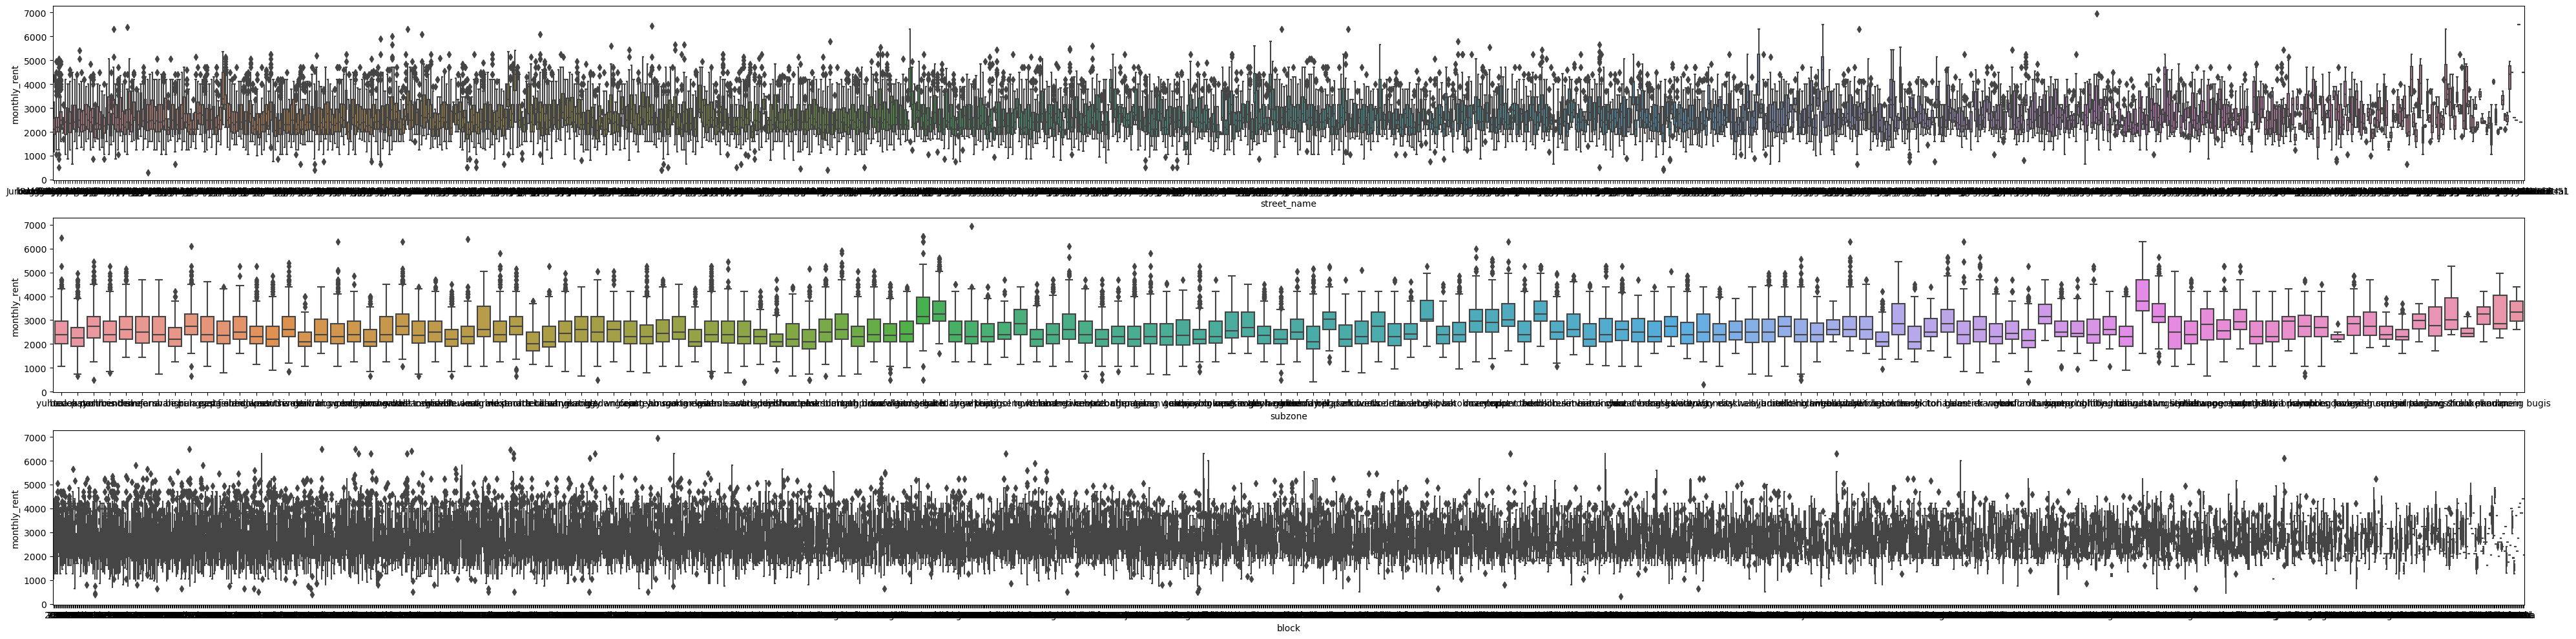

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(40, 10))
sns.boxplot(x='street_name', y='monthly_rent', data=df_train, ax=ax[0,])
sns.boxplot(x='subzone', y='monthly_rent', data=df_train, ax=ax[1,])
sns.boxplot(x='block', y='monthly_rent', data=df_train, ax=ax[2,])
plt.tight_layout()

## try with attributes > 0.3
* block
* street_name
* flat_type
* floor_area_sqm
* subzone
* rent_approval_date_mean
## with method
* xgboost
* lgbm

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import catboost as cb

In [24]:
def data_preprocess(df):
    df = df.copy()
    df['flat_type'] = df['flat_type'].str.replace('-', ' ')
    df.drop(['elevation'], axis=1, inplace=True)
    df.drop(['furnished'], axis=1, inplace=True)
    df.drop(['latitude'], axis=1, inplace=True)
    df.drop(['longitude'], axis=1, inplace=True)
    df['rent_date'] = pd.to_datetime(df['rent_approval_date']).dt.year + pd.to_datetime(df['rent_approval_date']).dt.month/12
    df.drop(['lease_commence_date'], axis=1, inplace=True)
    df.drop(['rent_approval_date'], axis=1, inplace=True)

    return df

In [25]:
df_train = pd.read_csv(path_prefix + 'train.csv')
df_test = pd.read_csv(path_prefix + 'test.csv')

In [26]:
#count test data has block in train data
df_train_block = df_train['block'].unique()
print(len(df_train_block))
df_test_block = df_test['block']
count = 0
for i in range(len(df_test_block)):
    if df_test_block[i] in df_train_block:
        count += 1
print(count)

2553
29921


In [27]:
df_train_X = data_preprocess(df_train)
df_train_X = df_train_X.drop(['monthly_rent'], axis=1)
df_train_y = df_train['monthly_rent']
df_test_X = data_preprocess(df_test)
df_test_X

,town,block,street_name,flat_type,flat_model,floor_area_sqm,subzone,planning_area,region,rent_date
0,hougang,245,hougang street 22,5 room,improved,121.0,lorong ah soo,hougang,north-east region,2023.083333
1,sembawang,316,sembawang vista,4 room,model a,100.0,sembawang central,sembawang,north region,2022.750000
2,clementi,708,Clementi West Street 2,4 room,new generation,91.0,clementi west,clementi,west region,2023.583333
3,jurong east,351,Jurong East Street 31,3 room,model a,74.0,yuhua west,jurong east,west region,2021.666667
4,jurong east,305,jurong east street 32,5 room,improved,121.0,yuhua west,jurong east,west region,2022.250000
...,...,...,...,...,...,...,...,...,...,...
29995,punggol,615b,edgefield plains,4 room,model a,92.0,waterway east,punggol,north-east region,2022.666667
29996,sembawang,491,admiralty link,4 room,model a,90.0,sembawang north,sembawang,north region,2023.166667
29997,ang mo kio,524,ang mo kio avenue 5,3 room,new generation,68.0,cheng san,ang mo kio,north-east region,2023.416667
29998,woodlands,656,woodlands ring road,executive,maisonette,144.0,woodlands east,woodlands,north region,2023.166667


In [28]:
df_train_X

,town,block,street_name,flat_type,flat_model,floor_area_sqm,subzone,planning_area,region,rent_date
0,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yuhua east,jurong east,west region,2021.750000
1,bedok,119,bedok north road,4 room,new generation,92.0,bedok north,bedok,east region,2022.416667
2,toa payoh,157,lorong 1 toa payoh,3 room,improved,67.0,toa payoh central,toa payoh,central region,2022.833333
3,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,pasir ris drive,pasir ris,east region,2021.666667
4,kallang/whampoa,34,Whampoa West,3 room,improved,68.0,bendemeer,kallang,central region,2022.916667
...,...,...,...,...,...,...,...,...,...,...
59995,ang mo kio,441,Ang Mo Kio Avenue 10,3 room,new generation,67.0,chong boon,ang mo kio,north-east region,2021.750000
59996,bukit merah,95a,henderson road,4 room,model a,83.0,henderson hill,bukit merah,central region,2023.333333
59997,tampines,862a,tampines street 83,5 room,improved,122.0,tampines west,tampines,east region,2022.500000
59998,bedok,67,Bedok Sth Avenue 3,5 room,standard,123.0,bedok south,bedok,east region,2023.083333


In [ ]:
df_train_X.dtypes

town               object
block              object
street_name        object
flat_type          object
flat_model         object
floor_area_sqm    float64
subzone            object
planning_area      object
region             object
rent_date         float64
dtype: object

In [ ]:
#predict with catboost
cat_features = list(df_train_X.select_dtypes(include=['object']).columns)
X_train, X_test, y_train, y_test = train_test_split(df_train_X, df_train_y, test_size=0.3, random_state=42)
model = cb.CatBoostRegressor(iterations=1000, learning_rate=0.01, loss_function='RMSE')
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), plot=True)
y_pred = model.predict(X_test)
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('RMSE: ', mean_squared_error(y_test, y_pred, squared=False))
df_plot_diff = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_test'] - df_plot_diff['y_pred']
df_plot_diff['diff'].plot()




MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE:  366.9330056291912
RMSE:  487.02234550757703


In [33]:
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [34]:
#cut 30% data as validation set
X_train, X_val, y_train, y_val = train_test_split(df_train_X, df_train_y, test_size=0.3, random_state=19260817)

MAE:  386.42517851631396
RMSE:  511.77823535560464


<Axes: >

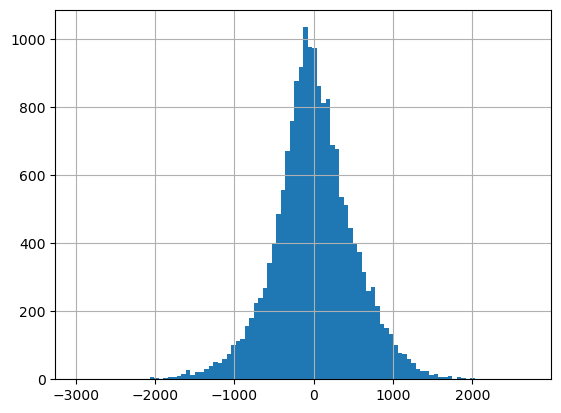

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

model = DecisionTreeRegressor()
model = RandomForestRegressor()
#model = GradientBoostingRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print('MAE: ', mean_absolute_error(y_val, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 842
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 6
[LightGBM] [Info] Start training from score 2586.378571
LGBM MAE:  369.4505640028098
LGBM RMSE:  489.88283632294014


<Axes: >

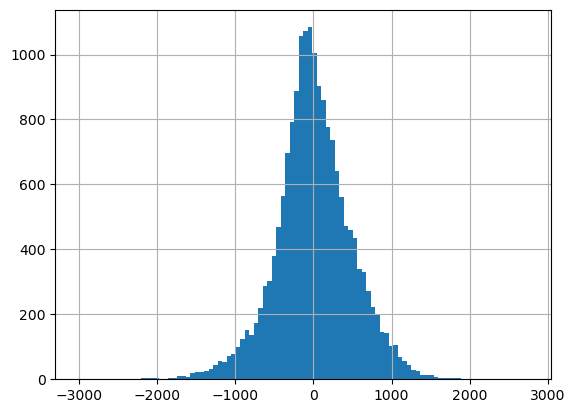

In [35]:
LGBM = LGBMRegressor(
    learning_rate=0.01,
    n_estimators=10000,
)

LGBM.fit(X_train, y_train)
y_pred = LGBM.predict(X_val)
print('LGBM MAE: ', mean_absolute_error(y_val, y_pred))
print('LGBM RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)



In [ ]:
#submit with xgboost
lgb = LGBMRegressor(
    learning_rate=0.01,
    n_estimators=10000,
)
lgb.fit(df_train_X, df_train_y)
y_pred = lgb.predict(df_test_X)
submit = pd.read_csv(path_prefix + 'example-submission.csv')
submit['Predicted'] = y_pred
submit.to_csv('submit_lgb.csv', index=False)


In [25]:
#feature importance
lgb_model = LGBMRegressor()
features = X_train.columns
dict_feature_importance = {}

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_val)

original_rmse = mean_squared_error(y_val, y_pred, squared=False)

for feature in features:
    X_train_tmp = X_train.drop([feature], axis=1)
    X_val_tmp = X_val.drop([feature], axis=1)
    lgb_model.fit(X_train_tmp, y_train)
    y_pred = lgb_model.predict(X_val_tmp)
    dict_feature_importance[feature] = mean_squared_error(y_val, y_pred, squared=False) - original_rmse


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 40234, number of used features: 6
[LightGBM] [Info] Start training from score 2515.556495
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 586
[LightGBM] [Info] Number of data points in the train set: 40234, number of used features: 5
[LightGBM] [Info] Start training from score 2515.556495
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

In [26]:
for feature in features:
    print(feature, '\t\t', dict_feature_importance[feature])

block 		 9.022356700334626
street_name 		 1.5255058497397727
flat_type 		 0.11590712983320373
floor_area_sqm 		 0.8644287486536086
subzone 		 4.256996620161146
rent_approval_date_mean 		 43.240753620437886


In [27]:
#tuning with different learning rate
learning_rate_list = list(np.arange(0.001, 0.1, 0.005))
LGBM_RMSE_list = []
for learning_rate in learning_rate_list:
    LGBM = LGBMRegressor(
        learning_rate=learning_rate,
        n_estimators=1000,
    )

    LGBM.fit(X_train, y_train)
    y_pred = LGBM.predict(X_val)
    LGBM_RMSE_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))

plt.figure(figsize=(20, 10))
plt.plot(learning_rate_list, LGBM_RMSE_list)
plt.xlabel('learning_rate')
plt.ylabel('RMSE')
plt.show()

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 40234, number of used features: 6
[LightGBM] [Info] Start training from score 2515.556495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 40234, number of used features: 6
[LightGBM] [Info] Start training from score 2515.556495
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Inf

KeyboardInterrupt: 

In [ ]:
#tuning with different depth
max_depth_list = list(np.arange(1, 20, 1))
LGBM_RMSE_list = []
for max_depth in max_depth_list:
    LGBM = LGBMRegressor(
        learning_rate=0.01,
        n_estimators=1000,
        max_depth=max_depth
    )

    LGBM.fit(X_train, y_train)
    y_pred = LGBM.predict(X_val)
    LGBM_RMSE_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))

plt.figure(figsize=(20, 10))
plt.plot(max_depth_list, LGBM_RMSE_list)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.show()

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 838
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 6
[LightGBM] [Info] Start training from score 2588.171667
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 838
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 6
[LightGBM] [Info] Start training from score 2588.171667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

KeyboardInterrupt: 

In [ ]:
#tuning parameters with grid search
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': list(np.arange(1, 20, 1)),
    'num_leaves': list(np.arange(2, 100, 1)),
}

LGBM = LGBMRegressor(
    learning_rate=0.01,
)

#RSME as the metric
grid_search = GridSearchCV(estimator=LGBM, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(grid_search.best_params_))
print('最佳模型得分:{0}'.format(grid_search.best_score_))


Fitting 5 folds for each of 1862 candidates, totalling 9310 fits
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1010
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 12
[LightGBM] [Info] Start training from score 2586.378571
参数的最佳取值:{'max_depth': 9, 'num_leaves': 99}
最佳模型得分:-525.9031647753602
[-609.00453305 -609.00453305 -609.00453305 ... -526.07229843 -526.06197112
 -526.00313521]
[{'max_depth': 1, 'num_leaves': 2}, {'max_depth': 1, 'num_leaves': 3}, {'max_depth': 1, 'num_leaves': 4}, {'max_depth': 1, 'num_leaves': 5}, {'max_depth': 1, 'num_leaves': 6}, {'max_depth': 1, 'num_leaves': 7}, {'max_depth': 1, 'num_leaves': 8}, {'max_depth': 1, 'num_leaves': 9}, {'max_depth': 1, 'num_leaves': 10}, {'max_depth': 1, 'num_leaves': 11}, {'max_depth': 1, 'num_leaves': 12}, {'max_depth': 1, 'num_leaves': 13}, {'

In [ ]:
param_grid = {
    'min_child_samples': list(np.arange(1, 100, 1)),
    'min_child_weight': list(np.arange(0.001, 0.1, 0.001)),
}

LGBM = LGBMRegressor(
    learning_rate=0.01,
    max_depth=grid_search.best_params_['max_depth'],
    num_leaves=grid_search.best_params_['num_leaves'],
)

#RSME as the metric
grid_search = GridSearchCV(estimator=LGBM, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(grid_search.best_params_))
print('最佳模型得分:{0}'.format(grid_search.best_score_))

Fitting 5 folds for each of 9801 candidates, totalling 49005 fits
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1010
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 12
[LightGBM] [Info] Start training from score 2586.378571
参数的最佳取值:{'min_child_samples': 27, 'min_child_weight': 0.001}
最佳模型得分:-525.7670705146129


In [ ]:
param_grid = {
    'bagging_fraction': list(np.arange(0.5, 1, 0.1)),
    'bagging_freq': list(np.arange(2, 10, 1)),
}

LGBM = LGBMRegressor(
    learning_rate=0.01,
    max_depth=9,
    num_leaves=99,
    min_child_samples=grid_search.best_params_['min_child_samples'],
    min_child_weight=grid_search.best_params_['min_child_weight'],
)

#RSME as the metric
grid_search = GridSearchCV(estimator=LGBM, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(grid_search.best_params_))
print('最佳模型得分:{0}'.format(grid_search.best_score_))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1010
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 12
[LightGBM] [Info] Start training from score 2586.378571
参数的最佳取值:{'bagging_fraction': 0.5, 'bagging_freq': 2}
最佳模型得分:-524.5259579352785


In [ ]:
param_grid = {
    'reg_alpha': list(np.arange(0, 1, 0.1)),
    'reg_lambda': list(np.arange(0, 1, 0.1)),
}

LGBM = LGBMRegressor(
    learning_rate=0.01,
    max_depth=9,
    num_leaves=99,
    min_child_samples=27,
    min_child_weight=0.001,
    bagging_fraction=grid_search.best_params_['bagging_fraction'],
    bagging_freq=grid_search.best_params_['bagging_freq'],
)

#RSME as the metric
grid_search = GridSearchCV(estimator=LGBM, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(grid_search.best_params_))
print('最佳模型得分:{0}'.format(grid_search.best_score_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1010
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 12
[LightGBM] [Info] Start training from score 2586.378571
参数的最佳取值:{'reg_alpha': 0.4, 'reg_lambda': 0.0}
最佳模型得分:-524.523652459007


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
LGBM MAE:  421.8853990092359
LGBM RMSE:  568.8284820303877


<Axes: >

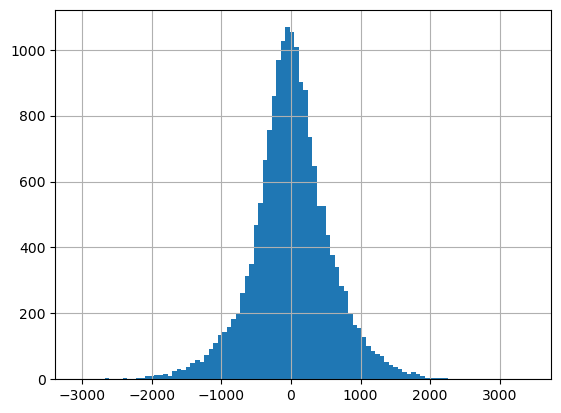

In [ ]:
LGBM = LGBMRegressor(
    learning_rate=0.01,
    n_estimators=50000,
    max_depth=9,
    num_leaves=99,
    min_child_samples=27,
    min_child_weight=0.001,
    bagging_fraction=0.5,
    bagging_freq=2,
    reg_alpha=grid_search.best_params_['reg_alpha'],
    reg_lambda=grid_search.best_params_['reg_lambda'],
)

LGBM.fit(X_train, y_train)
y_pred = LGBM.predict(X_val)
print('LGBM MAE: ', mean_absolute_error(y_val, y_pred))
print('LGBM RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)

XGB MAE:  360.91164501953125
XGB RMSE:  475.76614589791956


<Axes: >

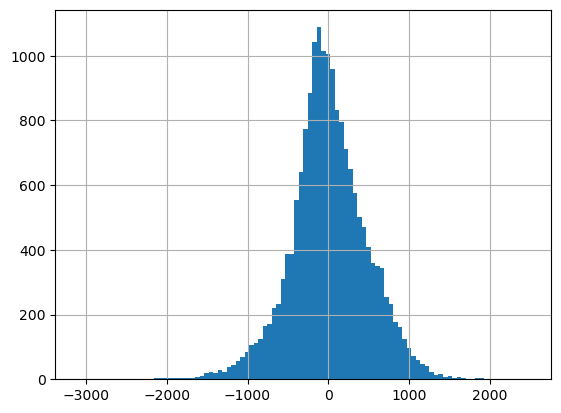

In [ ]:
xgb = XGBRegressor(
    learning_rate=0.01,
    n_estimators=1000,
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
print('XGB MAE: ', mean_absolute_error(y_val, y_pred))
print('XGB RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)

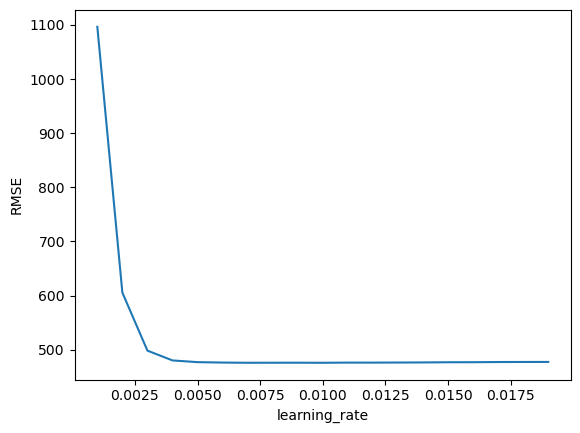

In [ ]:
#tuning with different learning rate
learning_rate_list = list(np.arange(0.001, 0.02, 0.001))
XGB_RMSE_list = []
for learning_rate in learning_rate_list:
    xgb = XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=1000,
    )

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_val)
    XGB_RMSE_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))

plt.plot(learning_rate_list, XGB_RMSE_list)
plt.xlabel('learning_rate')
plt.ylabel('RMSE')
plt.show()

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks


In [ ]:
def build_model(dim, activation='relu', optimizer='adam', loss='mse'):
    model = keras.Sequential([
        layers.Dense(dim, activation=activation, input_shape=[len(df_train_X.columns)]),
        layers.Dense(dim, activation=activation),
        layers.Dense(dim, activation=activation),
        layers.Dense(dim, activation=activation),
        layers.Dense(1, activation='linear')
    ])

    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    return model

In [ ]:
model = build_model(1024, activation='softplus', optimizer='adam', loss='mse')

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=10,
)

history = model.fit(
    df_train_X, df_train_y,
    validation_split=0.3,
    epochs=300,
    batch_size=4096,
    callbacks=[early_stopping]
)


Epoch 1/200
12/12 [==============================] - 0s 18ms/step - loss: 242681.7969 - mae: 377.2373 - val_loss: 234221.3594 - val_mae: 369.3957
Epoch 2/200
12/12 [==============================] - 0s 12ms/step - loss: 245132.5938 - mae: 379.5545 - val_loss: 239550.4062 - val_mae: 372.2088
Epoch 3/200
12/12 [==============================] - 0s 15ms/step - loss: 243425.9375 - mae: 377.8757 - val_loss: 241261.1875 - val_mae: 376.8472
Epoch 4/200
12/12 [==============================] - 0s 12ms/step - loss: 240905.5938 - mae: 376.2523 - val_loss: 237150.7656 - val_mae: 373.3318
Epoch 5/200
12/12 [==============================] - 0s 15ms/step - loss: 240885.3594 - mae: 376.0694 - val_loss: 238878.3438 - val_mae: 371.3596
Epoch 6/200
12/12 [==============================] - 0s 12ms/step - loss: 240137.7031 - mae: 375.0016 - val_loss: 236570.2031 - val_mae: 372.2632
Epoch 7/200
12/12 [==============================] - 0s 12ms/step - loss: 241053.8281 - mae: 376.1886 - val_loss: 234648.812